In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def c_generate(x_range):
    bin=len(x_range)
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=abs(x_range[i]-x_range[j])
    return C

def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]

def tmp_generator(gamma_dict,num,q_dict,q_num,L):
    bin=gamma_dict[0].shape[0]
    if q_num<=0:
        q=np.matrix(np.ones((bin,bin)))
    else:
        q=q_dict[q_num]
    tmp_gamma=np.zeros((bin,bin))
    tmp_q=np.zeros((bin,bin))
    for i in range(bin):
        for j in range(bin):
            tmp_gamma[i,j]=q.item(i,j)*gamma_dict[num-1].item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
            tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
    return np.matrix(tmp_gamma),np.matrix(tmp_q)     

def assess(bin,f,g,C,V,output):
    output=output.A1.reshape((bin,bin))
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f)))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g)))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('tr violation:',sum(abs(output.T@V)))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(3,3))
    gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    ax.set_xlabel(r'supp($X$)',fontsize=10)
    ax.set_ylabel(r'supp($\tilde{X}$)',fontsize=10)#
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx.set_title(r'$Pr[x]$',rotation='horizontal')
    #ax_histy.set_title(r'$Pr[\tilde{x}]$')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.plot(x_range,g,color='tab:blue')
    ax_histy.plot(f,x_range,color='tab:green') 
    return fig
    
def newton(fun,dfun,a, stepmax, tol):
    if abs(fun(a))<=tol: return a
    for step in range(1, stepmax+1):
        b=a-fun(a)/dfun(a)
        if abs(fun(b))<=tol:
            return b
        else:
            a = b
    return b 

# simplist
def baseline(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    #I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_classic=dict()
    gamma_classic[0]=np.matrix(xi+1.0e-9)
    for repeat in range(K):
        gamma_classic[1+2*repeat]=np.matrix(np.diag((px/(gamma_classic[2*repeat] @ bbm1)).A1))@gamma_classic[2*repeat] #np.diag(dist['x']/sum(gamma_classic.T))@gamma_classic
        gamma_classic[2+2*repeat]=gamma_classic[1+2*repeat]@np.matrix(np.diag((ptx/(gamma_classic[1+2*repeat].T @ bbm1)).A1))

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_classic[2*K])
    return gamma_classic

# our method | total repair
def total_repair(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    J=np.where(~((gamma_dict[2].T @ V).A1 ==0))[0].tolist()
    nu=np.zeros(bin)
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in J:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
        dfun = lambda z: sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        J=np.where(~((abs(np.matrix(tmp).T @ V).A1)<=1.0e-5))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in J:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
            dfun = lambda z: sum(tmp.item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[K*L])
    return gamma_dict

# our method | partial repair
def partial_repair(C,e,px,ptx,V,theta_scale,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    theta=bbm1*theta_scale
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    Jplus=np.where(~((gamma_dict[2].T @ V).A1 <=theta.A1))[0].tolist()
    Jminus=np.where(~((gamma_dict[2].T @ V).A1>=-theta.A1))[0].tolist()
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in Jplus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    for j in Jminus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        Jplus=np.where(~((np.matrix(tmp).T @ V).A1 <=theta.A1))[0].tolist()
        Jminus=np.where(~((np.matrix(tmp).T @ V).A1>=-theta.A1))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in Jplus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        for j in Jminus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[L*K])
    return gamma_dict

def empirical_distribution(sub,x_range):
    bin=len(x_range)
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==x_range[i]] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

def projection(df,coupling_matrix,x_range):
    bin=len(x_range)
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=['X','S','W','Y'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        loc=np.where(x_range==orig[0])[0][0]
        rows=np.nonzero(coupling[loc,:])[0]
        sub=pd.DataFrame(columns=['X','W'],index=rows)
        sub['X']=x_range[rows]
        sub['W']=coupling[loc,rows]/(sum(coupling[loc,rows]))*orig[2]
        sub['S']=orig[1]
        sub['Y']=orig[3]
        df_t=pd.concat([df_t, samples_groupby(sub)], ignore_index=True)
    return df_t

def plot_rdist(rdist,x_range):
    plt.plot(x_range,rdist['x'],label=r'$Pr[x]$',color='tab:blue')
    plt.plot(x_range,rdist['x_0'],label=r'$Pr[x|s_0]$',alpha=0.3,color='tab:orange')
    plt.plot(x_range,rdist['x_1'],label=r'$Pr[x|s_1]$',alpha=0.3,color='#9f86c0')
    plt.ylabel('PMF',fontsize=14)
    plt.xlabel(r'$supp(X)=supp(\tilde{X})$',fontsize=20)
    plt.legend()
    return plt

# def DisparateImpact(X_test,y_test,y_pred):
#     df_test=pd.DataFrame(np.concatenate((X_test,y_test.reshape(-1,1),y_pred.reshape(-1,1)), axis=1),columns=['X','S','W','Y','f'])
#     numerator=sum(df_test[(df_test['S']==0)&(df_test['f']==1)&(df_test['Y']==1)]['W'])/sum(df_test[(df_test['S']==0)&(df_test['Y']==1)]['W'])
#     denominator=sum(df_test[(df_test['S']==1)&(df_test['f']==1)&(df_test['Y']==1)]['W'])/sum(df_test[(df_test['S']==1)&(df_test['Y']==1)]['W'])
#     return numerator/denominator

# def DisparateImpact(X_test,y_pred):
#     df_test=pd.DataFrame(np.concatenate((X_test,y_pred.reshape(-1,1)), axis=1),columns=['X','S','W','f'])
#     numerator=sum(df_test[(df_test['S']==0)&(df_test['f']==1)]['W'])/sum(df_test[df_test['S']==0]['W'])
#     denominator=sum(df_test[(df_test['S']==1)&(df_test['f']==1)]['W'])/sum(df_test[df_test['S']==1]['W'])
#     if numerator==denominator:
#         return 1
#     return numerator/denominator

def DisparateImpact_postprocess(df_test,y_pred_tmp):
    df_test_tmp=df_test[:]
    df_test_tmp.insert(loc=0, column='f', value=y_pred_tmp)
    numerator=sum(df_test_tmp[(df_test_tmp['S']==0)&(df_test_tmp['f']==1)]['W'])/sum(df_test_tmp[df_test_tmp['S']==0]['W'])
    denominator=sum(df_test_tmp[(df_test_tmp['S']==1)&(df_test_tmp['f']==1)]['W'])/sum(df_test_tmp[df_test_tmp['S']==1]['W'])
    # if numerator==denominator:
    #     return 1
    return numerator/denominator

def rdata_analysis(rdata,x_range,x_name):
    rdist=dict()
    pivot=pd.pivot_table(rdata,index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    pivot0=pd.pivot_table(rdata[rdata['S']==0],index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    pivot1=pd.pivot_table(rdata[rdata['S']==1],index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    rdist['x']= np.array([pivot[i] for i in x_range])/sum([pivot[i] for i in x_range]) #empirical_distribution(rdata,x_range)
    rdist['x_0']=np.array([pivot0[i] if i in list(pivot0.index) else 0 for i in x_range])/sum([pivot0[i] if i in list(pivot0.index) else 0 for i in x_range]) #empirical_distribution(rdata[rdata['S']==0],x_range)
    rdist['x_1']=np.array([pivot1[i] if i in list(pivot1.index) else 0 for i in x_range])/sum([pivot1[i] if i in list(pivot1.index) else 0 for i in x_range]) #empirical_distribution(rdata[rdata['S']==1],x_range)
    return rdist

def c_generate_higher(x_range,weight):
    bin=len(x_range)
    dim=len(x_range[0])
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=sum(weight[d]*abs(x_range[i][d]-x_range[j][d]) for d in range(dim))
    return C

def projection_higher(df,coupling_matrix,x_range,x_list,var_list):
    df=df.drop(columns=x_list)
    dim=len(x_list)
    bin=len(x_range)
    arg_list=[elem for elem in var_list if elem not in x_list]
    df=df[arg_list+['X','S','W','Y']]
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=arg_list+['X','S','W','Y'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        loc=np.where([x_range[i]==orig['X'] for i in range(bin)])[0][0]
        rows=np.nonzero(coupling[loc,:])[0]
        sub_dict={'X':[x_range[r] for r in rows],'W':list(coupling[loc,rows]/(sum(coupling[loc,rows]))*orig['W'])}
        sub_dict.update({var:[orig[var]]*len(rows) for var in arg_list+['S','Y']})
        sub=pd.DataFrame(data=sub_dict, index=rows)
        df_t=pd.concat([df_t,sub],ignore_index=True)#pd.concat([df_t,samples_groupby(sub,x_list)], ignore_index=True)
    df_t=df_t.groupby(by=list(chain(*[arg_list,'X','S','Y'])),as_index=False).sum()
    for d in range(dim):
        df_t[x_list[d]]=[df_t['X'][r][d] for r in range(df_t.shape[0])]
    return df_t[var_list+['S','W','Y']]

# def postprocess(df_test,coupling_matrix,x_range,x_range_pred):
#     bin=len(x_range)
#     coupling=coupling_matrix.A1.reshape((bin,bin))
#     x_pred_repaired=[]
#     for loc in range(bin):
#         ##loc=np.where([x_range[i]==orig['X'] for i in range(bin)])[0][0]
#         rows=np.nonzero(coupling[loc,:])[0]
#         p0=sum(x_range_pred[:,0]*coupling[loc,rows]/(sum(coupling[loc,rows])))
#         p1=sum(x_range_pred[:,1]*coupling[loc,rows]/(sum(coupling[loc,rows])))
#         if p0>p1:
#             x_pred_repaired+=[0]
#         else:
#             x_pred_repaired+=[1]
#     pred_dict=dict(zip(x_range,x_pred_repaired))
#     f_repaired=[pred_dict[df_test['X'][i]] for i in range(df_test.shape[0])]
#     return np.array(f_repaired)

def postprocess(df_test,coupling_matrix,x_list,x_range,var_list,var_range,clf):
    var_dim=len(var_list)
    bin=len(x_range)
    x_loc_dict=dict(zip(x_range,[*range(bin)]))
    arg_list=[elem for elem in var_list if elem not in x_list]
    coupling=coupling_matrix.A1.reshape((bin,bin))

    ## add the case when var_dim=len(x_list)
    pred_repaired=dict()
    for i in range(len(var_range)):
        var_tmp=pd.Series({var_list[d]:var_range[i][d] for d in range(var_dim)})
        loc=x_loc_dict[tuple(var_tmp[x_list])]
        arg_info=dict(df_test.iloc[i][arg_list])
        sub=pd.DataFrame(x_range,columns=x_list)
        for arg in arg_list:
            sub[arg]=arg_info[arg]
        sub=sub[var_list]
        prob=np.array([clf.predict_proba(np.array(sub.loc[i]).reshape(-1,var_dim))[0] for i in range(sub.shape[0])])
        totalweight=sum(coupling[loc,:])
        p0=sum(prob[:,0]*coupling[loc,:]/totalweight)
        p1=sum(prob[:,1]*coupling[loc,:]/totalweight)
        pred_repaired.update({var_range[i]:int(p0<p1)})
    return np.array([pred_repaired[tuple(df_test[var_list].iloc[i])] for i in range(df_test.shape[0])])

In [218]:
x_list

['hoursperweek', 'age', 'education-num']

In [207]:
tv_dist=dict()
for x_name in var_list:
    x_range_single=list(pd.pivot_table(messydata,index=x_name,values=['W'])[('W')].index) 
    dist=rdata_analysis(messydata,x_range_single,x_name)
    tv_dist[x_name]=sum(abs(dist['x_0']-dist['x_1']))
tv_dist

{'hoursperweek': 0.36377408313106424,
 'age': 0.2020455377733658,
 'capitalgain': 0.07384935142758571,
 'capitalloss': 0.04013771192852693,
 'education-num': 0.1419094677045439}

In [7]:
tv_dist=dict()
for x_name in var_list:
    x_range_single=list(pd.pivot_table(messydata,index=x_name,values=['W'])[('W')].index) 
    dist=rdata_analysis(messydata,x_range_single,x_name)
    tv_dist[x_name]=sum(abs(dist['x_0']-dist['x_1']))
tv_dist

{'hoursperweek': 0.2443234639017859,
 'age': 0.08298460294670768,
 'capitalgain': 0.053529107898460285,
 'capitalloss': 0.028435566957486356,
 'education-num': 0.23735926565013912}

In [6]:
K=150
e=0.01

var_list=['hoursperweek','age','capitalgain','capitalloss' ,'education-num'] #class must be in the end ,,'capitalloss' ,'education-num'
var_dim=len(var_list)
pa='race'
pa_dict={'Male':1,'Female':0,'White':1,'Black':0}

messydata=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/adult_csv.csv',usecols=var_list+[pa,'class'])
messydata=messydata.rename(columns={pa:'S','class':'Y'})
messydata['S']=messydata['S'].replace(pa_dict)
messydata['Y']=messydata['Y'].replace({'>50K':1,'<=50K':0})
messydata=messydata[(messydata['S']==1)|(messydata['S']==0)]
for col in var_list+['S','Y']:
    messydata[col]=messydata[col].astype('category')
messydata['W']=1

X=messydata[var_list+['S','W']].to_numpy() # [X,S,W]
y=messydata['Y'].to_numpy() #[Y]

tv_dist=dict()
for x_name in var_list:
    x_range_single=list(pd.pivot_table(messydata,index=x_name,values=['W'])[('W')].index) 
    dist=rdata_analysis(messydata,x_range_single,x_name)
    tv_dist[x_name]=sum(abs(dist['x_0']-dist['x_1']))
x_list=[]
for key,val in tv_dist.items():
    if val>0.:
        x_list+=[key]

In [516]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train[:,0:var_dim],y_train)

df_test=pd.DataFrame(np.concatenate((X_test,y_test.reshape(-1,1)), axis=1),columns=var_list+['S','W','Y'])
df_test=df_test.groupby(by=var_list+['S','Y'],as_index=False).sum()

In [517]:
df_test['X']=[tuple(df_test[x_list].values[r]) for r in range(df_test.shape[0])]
x_range=list(set(df_test['X'])) #list(pd.pivot_table(df_test,index=var_list,values=['W']).index) # class in the end
weight=list(1/(df_test[x_list].max()-df_test[x_list].min())) # because 'education-num' range from 1 to 16 while others 1 to 4
bin=len(x_range)

In [518]:
var_range=list(pd.pivot_table(df_test,index=var_list,values=['S','W','Y']).index)

In [253]:
def rdata_analysis(rdata,x_range,x_name):
    rdist=dict()
    pivot=pd.pivot_table(rdata,index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    pivot0=pd.pivot_table(rdata[rdata['S']==0],index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    pivot1=pd.pivot_table(rdata[rdata['S']==1],index=x_name,values=['W'],aggfunc=[np.sum])[('sum','W')]
    rdist['x']= np.array([pivot[i] for i in x_range])/sum([pivot[i] for i in x_range]) #empirical_distribution(rdata,x_range)
    rdist['x_0']=np.array([pivot0[i] if i in list(pivot0.index) else 0 for i in x_range])/sum([pivot0[i] if i in list(pivot0.index) else 0 for i in x_range]) #empirical_distribution(rdata[rdata['S']==0],x_range)
    rdist['x_1']=np.array([pivot1[i] if i in list(pivot1.index) else 0 for i in x_range])/sum([pivot1[i] if i in list(pivot1.index) else 0 for i in x_range]) #empirical_distribution(rdata[rdata['S']==1],x_range)
    return rdist

In [519]:
dist=rdata_analysis(df_test,x_range,'X')
dist['t_x']=dist['x'] # #dist['x'] #dist['x_0']*0.5+dist['x_1']*0.5 
dist['v']=[(dist['x_0'][i]-dist['x_1'][i])/dist['x'][i] for i in range(bin)]
px=np.matrix(dist['x']).T
ptx=np.matrix(dist['t_x']).T
V=np.matrix(dist['v']).T
if len(x_list)>1:
    C=c_generate_higher(x_range,weight)
else:
    C=c_generate(x_range)

In [283]:
var_range_pred=clf.predict_proba(np.array(var_range))
coupling_matrix=baseline(C,e,px,ptx,V,K)[K*2]
bin=len(x_range)
coupling=coupling_matrix.A1.reshape((bin,bin))

sum of violation of f: 2.069637270374e-08
sum of violation of g: 9.497611030973019e-17
total cost: 1.8173783658035824e-08
entropy: 2.702872768709467
tr violation: [[0.41926414]]


In [535]:
clf.predict_proba(var_range)[:,0]

array([0.98744151, 0.986582  , 0.49354165, 0.90994903, 0.92634022,
       0.7131643 , 0.79787174, 0.85037122, 0.56421739, 0.12108398,
       0.12203067, 0.78650319, 0.54243933, 0.12046284, 0.8603514 ,
       0.91492851, 0.70874598, 0.16383535, 0.98176364, 0.98159358,
       0.90278861, 0.21674434, 0.91328854, 0.92841301, 0.74061893,
       0.7943213 , 0.83415448, 0.51948521, 0.10105466, 0.78295274,
       0.81736817, 0.51595525, 0.10252917, 0.09970181, 0.84957326,
       0.89022929, 0.65010999, 0.15958245, 0.11586028, 0.96153621,
       0.95018052, 0.81603091, 0.04139783, 0.05896751, 0.87089576,
       0.86912083, 0.66149251, 0.01993208, 0.02240208, 0.72141309,
       0.75904263, 0.36794091, 0.07424304, 0.07619268, 0.70818921,
       0.73902627, 0.38206455, 0.07687051, 0.07901491, 0.73705587,
       0.80664179, 0.44976473, 0.05572991, 0.06299157, 0.89516562,
       0.89441976, 0.51556935, 0.09119061, 0.0612896 , 0.74610327,
       0.76604794, 0.49896359, 0.01590377, 0.01726968, 0.56107

In [522]:
postprocess(df_test,baseline(C,e,px,ptx,V,K)[K*2],x_list,x_range,var_list,var_range,clf)

sum of violation of f: 2.0508631314031245e-08
sum of violation of g: 6.071532165918825e-17
total cost: 1.815999332300348e-08
entropy: 2.713232310665811
tr violation: [[0.45152976]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [526]:
y_pred_base=postprocess(df_test,baseline(C,e,px,ptx,V,K)[K*2],x_list,x_range,var_list,var_range,clf)
y_pred_part2=postprocess(df_test,partial_repair(C,e,px,ptx,V,1.0e-3,K)[K*3],x_list,x_range,var_list,var_range,clf)

sum of violation of f: 2.0508631314031245e-08
sum of violation of g: 6.071532165918825e-17
total cost: 1.815999332300348e-08
entropy: 2.713232310665811
tr violation: [[0.45152976]]
sum of violation of f: 0.004799760467037271
sum of violation of g: 0.000202957095201801
total cost: 0.26069352562185055
entropy: 3.5757447387801187
tr violation: [[0.0250041]]


In [527]:
y_pred=clf.predict(np.array(df_test[var_list]))

In [528]:
new_row=pd.Series({'DI':DisparateImpact_postprocess(df_test,y_pred),
                    'f1 macro':f1_score(df_test['Y'], y_pred, average='macro',sample_weight=df_test['W']),
                    'f1 micro':f1_score(df_test['Y'], y_pred, average='micro',sample_weight=df_test['W']),
                    'f1 weighted':f1_score(df_test['Y'], y_pred, average='weighted',sample_weight=df_test['W']),
                    'method':'origin'})
new_row_base=pd.Series({'DI':DisparateImpact_postprocess(df_test,y_pred_base),
                    'f1 macro':f1_score(df_test['Y'], y_pred_base, average='macro',sample_weight=df_test['W']),
                    'f1 micro':f1_score(df_test['Y'], y_pred_base, average='micro',sample_weight=df_test['W']),
                    'f1 weighted':f1_score(df_test['Y'], y_pred_base, average='weighted',sample_weight=df_test['W']),
                    'method':'baseline'})
new_row_part2=pd.Series({'DI':DisparateImpact_postprocess(df_test,y_pred_part2),
                    'f1 macro':f1_score(df_test['Y'], y_pred_part2, average='macro',sample_weight=df_test['W']),
                    'f1 micro':f1_score(df_test['Y'], y_pred_part2, average='micro',sample_weight=df_test['W']),
                    'f1 weighted':f1_score(df_test['Y'], y_pred_part2, average='weighted',sample_weight=df_test['W']),
                    'method':'partial repair2'})

In [529]:
print(new_row)

DI             0.476761
f1 macro       0.595535
f1 micro       0.794377
f1 weighted     0.74067
method           origin
dtype: object


In [530]:
print(new_row_base)

DI             0.662604
f1 macro       0.551191
f1 micro       0.707159
f1 weighted    0.686593
method         baseline
dtype: object


In [531]:
print(new_row_part2)

DI                    0.952927
f1 macro              0.531725
f1 micro              0.722105
f1 weighted            0.68453
method         partial repair2
dtype: object


In [5]:
report=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/report_postprocess_sex.csv')
performance=list(report.columns)[:-1]
methods=['origin','baseline','partial_repair2','partial_repair3'] #,'partial_repair4'
#list(set(report['method']))
colors=['#5f0f40','#9a031e','#FF8811','#F4D06F','#9DD9D2']
pivot=pd.pivot_table(report,index=['method'],values=performance,aggfunc=[np.mean,np.std])
pivot

mean                                       std            \
                       DI  f1 macro  f1 micro f1 weighted        DI  f1 macro   
method                                                                          
baseline         0.444584  0.690722  0.820128    0.794937  0.026394  0.006845   
origin           0.444584  0.690722  0.820128    0.794937  0.026394  0.006845   
partial_repair2  0.455476  0.687900  0.819605    0.793511  0.020154  0.008359   
partial_repair3  0.588335  0.607355  0.798995    0.750266  0.022141  0.008793   

                                       
                 f1 micro f1 weighted  
method                                 
baseline         0.003593    0.005363  
origin           0.003593    0.005363  
partial_repair2  0.004204    0.006285  
partial_repair3  0.003537    0.005910

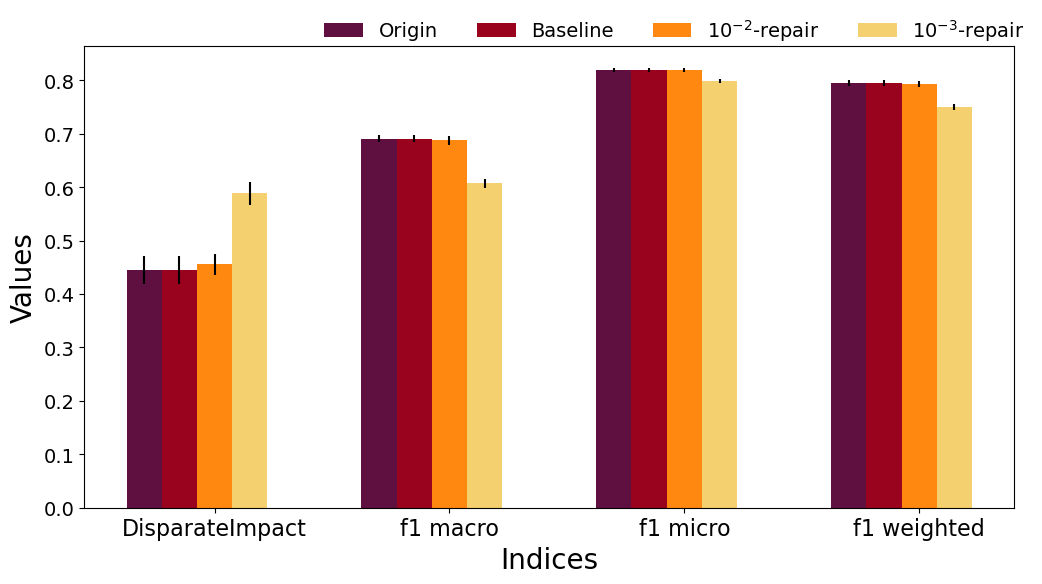

In [6]:
ind=np.arange(len(performance))
width = 0.15

fig, ax1 = plt.subplots(figsize=(12,6))

i=0
for m in methods:
    sub=[pivot[('mean',p)][m] for p in performance]
    err=[pivot[('std',p)][m] for p in performance]
    ax1.bar(ind+width*i,sub,width,yerr=err,color=colors[i],label=m)
    i+=1
    
ax1.legend(['Origin','Baseline',r'$10^{-2}$-repair',r'$10^{-3}$-repair',r'$5\times 10^{-4}$-repair'],fontsize=14,
            framealpha=0.2,bbox_to_anchor=(1.03,1.1),ncol=5,frameon=False)
ax1.set_xlabel('Indices', fontsize=20)
ax1.set_ylabel('Values', fontsize=20)

ax1.set_xticks(ind+width*2)
ax1.set_xticklabels(['DisparateImpact']+[i for i in performance[1:]], fontsize=16)
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#plt.savefig("C:/Users/zhouq/Documents/optimal_transport/adult_higher.pdf",bbox_inches='tight')